# Single Entity AI Inference Service : Seller Side

The code below an image classification service on the dopamine network, in return of at least 100 DOPA weis

for running this sample we need the following libraries:

In [1]:
import dopapy
import dopapy.trading as dp
import dopapy.types as dd
from PIL import Image #used to display the image here
from tensorflow.python.keras.applications import VGG16 #could also be ResNet50, InceptionV3, Xception, VGG19
from tensorflow.python.keras._impl.keras.applications import imagenet_utils
from tensorflow.python.keras.applications.inception_v3 import preprocess_input
from tensorflow.python.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from IPython.display import display
from urllib.request import urlopen

In [2]:
import warnings
warnings.filterwarnings('ignore') #Thats just to ignore warnings that are irrelevant for this type of sample

Some initializations made before using the VGG pretrained model, which is used for classification:

In [3]:
#Code below loads the network weights from disk 
#If this is the first time you are running this script for a given network, the weights will need to be downloaded first depending on which network is being used. the weights will be cached and subsequent runs of this script will be faster
print("Loading model...")
Network = VGG16
model = Network(weights="imagenet")
#initialize the input image shape (224x224 pixels) along with the pre-processing function (this might need to be changed based on which model we use to classify our image)
inputShape = (224, 224)
preprocess = imagenet_utils.preprocess_input
# if we are using the InceptionV3 or Xception networks, then we need to set the input shape to (299x299) [rather than (224x224)] and use a different image processing function
# if model in ("inception", "xception"):
# 	inputShape = (299, 299)
# 	preprocess = preprocess_input
print ('Model loaded')

Loading model...
Model loaded


Function below classifies an image using the VGG model:

In [4]:
def classify_image(img):
    image =img.resize(inputShape,Image.ANTIALIAS)    
    display(image)
    image = np.expand_dims(image, axis=0) # Expanding dimension by making the shape (1, inputShape[0], inputShape[1], 3), so we can pass it through the network    
    print("Classifying image ...")
    preds = model.predict(image)
    P = imagenet_utils.decode_predictions(preds)
    for (i, (imagenetID, label, prob)) in enumerate(P[0]):
        print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))        
    _, label, prob = P[0][0]
    return label

Testing the function using an image from web:

Loading image...


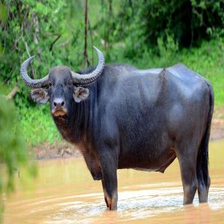

Classifying image ...
1. water_buffalo: 59.83%
2. ox: 39.39%
3. oxcart: 0.36%
4. bison: 0.32%
5. Indian_elephant: 0.05%


'water_buffalo'

In [5]:
print("Loading image...")
imageurl = "https://sites.google.com/a/wornickjds.org/endangered-animals-class-of-2019/_/rsrc/1467035359217/home/wild-water-buffalo/Jonah-wild%20water%20buffalo.jpg"
img =Image.open(urlopen(imageurl))
classify_image(img)

Wrapping the classification function to work with dopapy types:

In [6]:
def my_service(image):
    return dd.String(classify_image(image.data))

Creating a session object that represents the web service hosted by the user.
This session will have access to a local Ethereum wallet

In [7]:
session = dp.create_session(master_password='password123456',
                            keystore_dir='/data/dopamine/keystore_dir_b/',
                            web_server_host="127.0.0.1",
                            dopmn_budget=0,  # Do not allow to spend DOPAs from this account
                            ether_budget=int(10E18),
                            web_server_port=8003)

Checking balance before the trade:

In [8]:
print('DOPA Balance:',session.wallet.dopmn_balance)
print('ETH  Balance:',session.wallet.ether_balance)

DOPA Balance: 1000000000012169
ETH  Balance: 10000000000000000000


Describing the service for sale : image classification

In [9]:
my_service_descriptor = dd.ServiceDescriptor(
    service_role=dd.ServiceRole.PROVIDER,
    input_descriptors=[dd.ImageDescriptor()],
    output_descriptors=[dd.StringDescriptor()]
)

Creating a quote for selling the given image for at least 100 DOPA weis:

In [10]:
quote = dp.create_quote_services(
    service_callback=my_service,
    session=session,
    service_descriptor=my_service_descriptor,
    side=dp.SELL,
    reward_descriptor=dp.create_reward_descriptor(min_dopamine_price=int(100)))

Placing the quote on the dopamine network, waiting for buyers

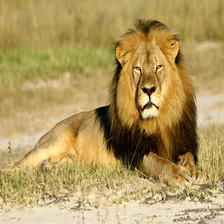

Classifying image ...
1. lion: 99.96%
2. cougar: 0.03%
3. macaque: 0.00%
4. tiger: 0.00%
5. lynx: 0.00%


In [11]:
quote.publish()

Here you need to wait for the other side to purchase...

<img src='../img/waiting.png'>

Checking balance after the trade:

In [12]:
print('DOPA Balance:',session.wallet.dopmn_balance)
print('ETH  Balance:',session.wallet.ether_balance)

DOPA Balance: 1000000000011309
ETH  Balance: 10000000000000000000
